# Texture networks

Texture generating networks (as described in <a href=https://arxiv.org/abs/1603.03417>the article</a>)

In [1]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline


# Style image to use.
STYLE_IMAGE = 'images/strawberries200x129.jpg'

# Image dimensions constants. 
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 129
COLOR_CHANNELS = 3

VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'

# The mean to subtract from the input to the VGG model. This is the mean that
# when the VGG was used to train. Minor changes to this will make a lot of
# difference to the performance of model.
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

VGG-19 part was taken from https://github.com/log0/neural-style-painting and require this <a href=https://drive.google.com/file/d/0B8QJdgMvQDrVU2cyZjFKU1RrLUU/view?usp=sharing>file</a>.

In [2]:
def load_vgg_model(path, model_input=None, h=IMAGE_HEIGHT, w=IMAGE_WIDTH):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)
    
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    if model_input == None:
        graph['input'] = tf.Variable(np.zeros((1, h, w, COLOR_CHANNELS)), dtype = 'float32')
    else:
        graph['input']   = model_input
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

def load_image(path):
    image = scipy.misc.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)
    
def show(image):
    image = image + MEAN_VALUES
    image = image[0]
    imshow(np.clip(image, 0, 255).astype('uint8'))

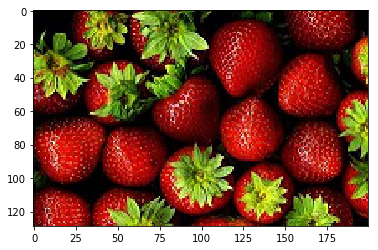

In [3]:
style_image = load_image(STYLE_IMAGE)
show(style_image)

In [4]:
# Original reference layers from the article
# STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Reference layers that were choosen in the github code by Dmitry Ulyanov
STYLE_LAYERS = ['conv1_2', 'conv2_2', 'conv3_2', 'conv4_2']


# Getting reference layers for original image
style_ref = {}
with tf.Session() as session:
    model = load_vgg_model(VGG_MODEL)
    session.run(model['input'].assign(style_image))
    res = session.run([model[layer_name] for layer_name in STYLE_LAYERS])
    style_ref = {name : res[i] for i, name in enumerate(STYLE_LAYERS)}

# Define graph for generating network

Create an TensorFlow session and define generating part (pyramid model from the article)

In [5]:
sess = tf.InteractiveSession()

batch_size = 8

# To generate change shape here
#input_image = tf.random_normal(shape=tf.shape(content_image), mean=0.0, stddev=1, dtype=tf.float32)
input_image = tf.random_uniform(shape=(batch_size, 200, 129, 3), minval=-1, maxval=1)

In [6]:
ratios = [32, 16, 8, 4, 2, 1]
conv_num = 8
ALPHA = 0.01 # Leaky ReLU constant. Used for PReLU initialization


def _weigths(height, width, channels):
    initializer = tf.contrib.layers.xavier_initializer(uniform=False)
    w = tf.Variable(initializer([height, height, width, channels]), name='w')
    b = tf.Variable(tf.zeros([channels]), name='b')
    return w, b


# A block, as described in the article
def _block(previous, N, S, name=''):
    
    # Mirror padding
    p = N // 2
    mirrored = tf.pad(previous, [[0, 0], [p, p], [p, p], [0, 0]], mode='SYMMETRIC')
    
    with tf.name_scope(name) as scope:
        w, b = _weigths(N, previous.shape[3].value, S)
        a = tf.Variable(ALPHA, name='a') # for PReLU
    
    conv =  tf.nn.conv2d(mirrored, w, strides=[1, 1, 1, 1], padding='VALID')
    normalized = tf.layers.batch_normalization(conv + b)
    
    # return PReLU
    return tf.maximum(0.0, normalized) + a * tf.minimum(0.0, normalized)

def _join(small, big):
    s = [big.shape[1].value, big.shape[2].value]
    upsampled = tf.image.resize_images(small, s, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    b_normed = tf.layers.batch_normalization(big)
    s_normed = tf.layers.batch_normalization(upsampled)
    return tf.concat([b_normed, s_normed], axis=3)

b = {}
for ix, r in enumerate(ratios):
    i = str(r)
    
    pooled = tf.nn.avg_pool(input_image, [1, r, r, 1], [1, r, r, 1], padding='SAME')
    b['1_' + i] = _block(pooled, 3, 8, name='b1_' + i)
    b['2_' + i] = _block(b['1_' + i], 3, 8, name='b2_' + i)
    b['3_' + i] = _block(b['2_' + i], 1, 8, name='b3_' + i)
    if ix > 0:
        b['joined_' + i] = _join(b['res_' + str(ratios[ix-1])], b['3_' + i])
        d = b['joined_' + i].shape[3].value
        
        b['joined_1_' + i] = _block(b['joined_' + i], 3, d, name='joined_1_' + i)
        b['joined_2_' + i] = _block(b['joined_1_' + i], 3, d, name='joined_2_' + i)
        b['res_' + i] = _block(b['joined_2_' + i], 1, d, name='res_' + i)
    else:
        b['res_' + i] = b['3_' + i]
        

result = _block(b['res_%d' % ratios[-1]], 1, 3, name='result')        

# Restore model to generate images

To generate texture with arbitrary size, we need to recreate graph with new first layer and restore already learned convolutional weights for given texture.

Skip this part if you want to train.

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, 'pines_temp.ckpt')
print("Model restored.")

INFO:tensorflow:Restoring parameters from pines_temp.ckpt


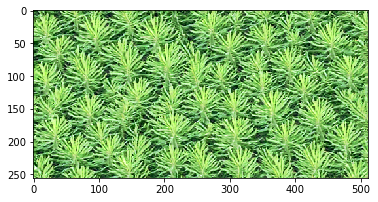

In [10]:
generated_image = sess.run(result[0])
show(generated_image)

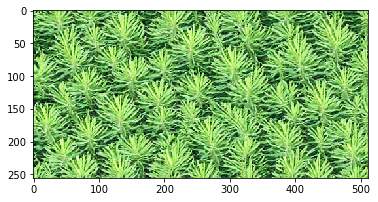

In [12]:
generated_image = sess.run(result[0])
show(generated_image)

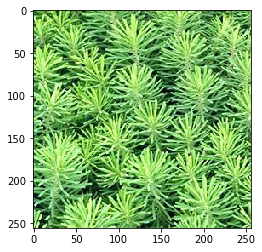

In [11]:
show(style_image)

In [13]:
save_image('output/512/8.png', generated_image)

# Add VGG-19 to the graph and define loss function
This part is only needed for training.

In [7]:
model = load_vgg_model(VGG_MODEL, result)

In [8]:
def _gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(Ft), Ft)

def _style_loss(a, x):
    # N is the number of filters (at layer l).
    N = a.shape[3]
    # M is the height times the width of the feature map (at layer l).
    M = a.shape[1] * a.shape[2]
    # A is the style representation of the original image (at layer l).
    A = _gram_matrix(a, N, M)
    # G is the style representation of the generated image (at layer l).
    G = _gram_matrix(x, N, M)
    result = (1 / (4 * N**2 * M**2) / batch_size) * tf.reduce_sum(tf.pow(G - A, 2))
    return result


loss = 0
for i in range(batch_size):
    E = [_style_loss(style_ref[layer_name],
                     model[layer_name][i]) for layer_name in STYLE_LAYERS]
    #W = [0.5, 1.0, 1.5, 3.0, 4.0]
    W = [1, 1, 1, 1, 1]
    loss = loss + sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])

Summaries for TensorBoard

In [9]:
tf.summary.scalar('loss', loss)
tf.summary.image('texture', result, max_outputs=1)
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('logs/strawberries', sess.graph)

saver = tf.train.Saver()

For batch size 3, learning rate should be around $10^{-3}$. For bigger batches one should use bigger learning rate.

In [10]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.005, global_step, 2000, 0.9, staircase=True)


optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss, global_step=global_step)

In [ ]:
tf.global_variables_initializer().run()

# Restore to additional learning here:
You may want to train some model a little more. If that's the case, restore model here. Skip otherwise.

In [12]:
saver.restore(sess, 'simon_pine.ckpt')
print("Model restored.")

INFO:tensorflow:Restoring parameters from simon_pine.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for simon_pine.ckpt
	 [[Node: save/RestoreV2_162 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_162/tensor_names, save/RestoreV2_162/shape_and_slices)]]

Caused by op 'save/RestoreV2_162', defined at:
  File "/home/nomenou/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/nomenou/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-9565e9088676>", line 7, in <module>
    saver = tf.train.Saver()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/nomenou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for simon_pine.ckpt
	 [[Node: save/RestoreV2_162 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_162/tensor_names, save/RestoreV2_162/shape_and_slices)]]


# Learning cycle

In [ ]:
ITERATIONS = 500001

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%20 == 0:
        writer.add_summary(sess.run(merged), it)
    if it%500 == 0:
        # Print every 100 iteration.
        mixed_image = sess.run(result)
        c = sess.run(loss)
        
        writer.add_summary(sess.run(merged), it)
        print('Iteration %d' % (global_step.eval()))
        print('learning rate: %0.5f' % sess.run(learning_rate))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', c)
        imshow(mixed_image[0])
        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d_%10.0f.png' % (global_step.eval(), np.log10(c))
        save_image(filename, mixed_image)
    if it%1000 == 0 and it > 0:
        save_path = saver.save(sess, 'straw_small_temp.ckpt')
        print('Model saved in file: %s' % save_path)

Iteration 1
learning rate: 0.00500
sum :  117392.0
cost:  8.62107e+09
Iteration 201
learning rate: 0.00500
sum :  2344.24
cost:  8.62127e+09
Model saved in file: straw_small_temp.ckpt
Iteration 3601
learning rate: 0.00450
sum :  2.83873e+07
cost:  1.39036e+09
Iteration 3801
learning rate: 0.00450
sum :  2.80633e+07
cost:  1.22742e+09
Iteration 4001
learning rate: 0.00405
sum :  2.6266e+07
cost:  1.22281e+09
Model saved in file: straw_small_temp.ckpt
Iteration 4201
learning rate: 0.00405
sum :  2.76663e+07
cost:  1.23944e+09
Iteration 4401
learning rate: 0.00405
sum :  2.78306e+07
cost:  1.17599e+09
Model saved in file: straw_small_temp.ckpt
Iteration 4601
learning rate: 0.00405
sum :  2.50021e+07
cost:  1.201e+09
Iteration 4801
learning rate: 0.00405
sum :  2.73145e+07
cost:  1.16047e+09
Iteration 5001
learning rate: 0.00405
sum :  2.62199e+07
cost:  1.16474e+09
Model saved in file: straw_small_temp.ckpt
Iteration 5201
learning rate: 0.00405
sum :  2.67392e+07
cost:  1.09985e+09
Iterat

# Save model

Be careful not to overwrite existing models.

In [20]:
saver = tf.train.Saver()
save_path = saver.save(sess, '123456.ckpt')
print('Model saved in file: %s' % save_path)

Model saved in file: simon_radishes2.ckpt


# Compare results and save images

In [14]:
sess.run(global_step)

20530

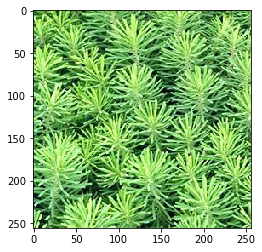

In [15]:
show(style_image)

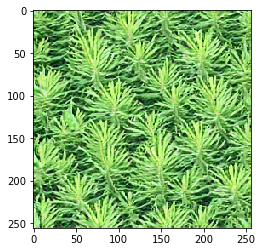

In [16]:
show(sess.run(result[0]))

In [35]:
save_image('output/art.jpg', mixed_image)